In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import warnings
from sklearn.model_selection import train_test_split

warnings.simplefilter('ignore')

## Prepare data

In [7]:
red_train = pd.read_csv("data/winequality-red_train.csv")
white_train = pd.read_csv("data/winequality-white_train.csv")
red_goal = pd.read_csv("data/winequality-red_goal.csv")
white_goal = pd.read_csv("data/winequality-white_goal.csv")

red_goal.drop(columns='quality', inplace=True)
white_goal.drop(columns='quality', inplace=True)

#combine training data for simpler training
#red(0) white(1)
red_train_c = red_train.copy()
red_train_c['color'] = 0
white_train_c = white_train.copy()
white_train_c['color'] = 1
df = pd.concat([red_train_c, white_train_c], ignore_index=True)
df.info()
df.drop(columns='color', inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5198 entries, 0 to 5197
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         5198 non-null   float64
 1   volatile acidity      5198 non-null   float64
 2   citric acid           5198 non-null   float64
 3   residual sugar        5198 non-null   float64
 4   chlorides             5198 non-null   float64
 5   free sulfur dioxide   5198 non-null   float64
 6   total sulfur dioxide  5198 non-null   float64
 7   density               5198 non-null   float64
 8   pH                    5198 non-null   float64
 9   sulphates             5198 non-null   float64
 10  alcohol               5198 non-null   float64
 11  quality               5198 non-null   int64  
 12  color                 5198 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 528.0 KB


In [8]:
train_data, test_data = train_test_split(df, test_size=0.2, random_state=123, stratify=df['quality'])

## data observation

array([[<Axes: title={'center': 'fixed acidity'}>,
        <Axes: title={'center': 'volatile acidity'}>,
        <Axes: title={'center': 'citric acid'}>],
       [<Axes: title={'center': 'residual sugar'}>,
        <Axes: title={'center': 'chlorides'}>,
        <Axes: title={'center': 'free sulfur dioxide'}>],
       [<Axes: title={'center': 'total sulfur dioxide'}>,
        <Axes: title={'center': 'density'}>,
        <Axes: title={'center': 'pH'}>],
       [<Axes: title={'center': 'sulphates'}>,
        <Axes: title={'center': 'alcohol'}>,
        <Axes: title={'center': 'quality'}>]], dtype=object)

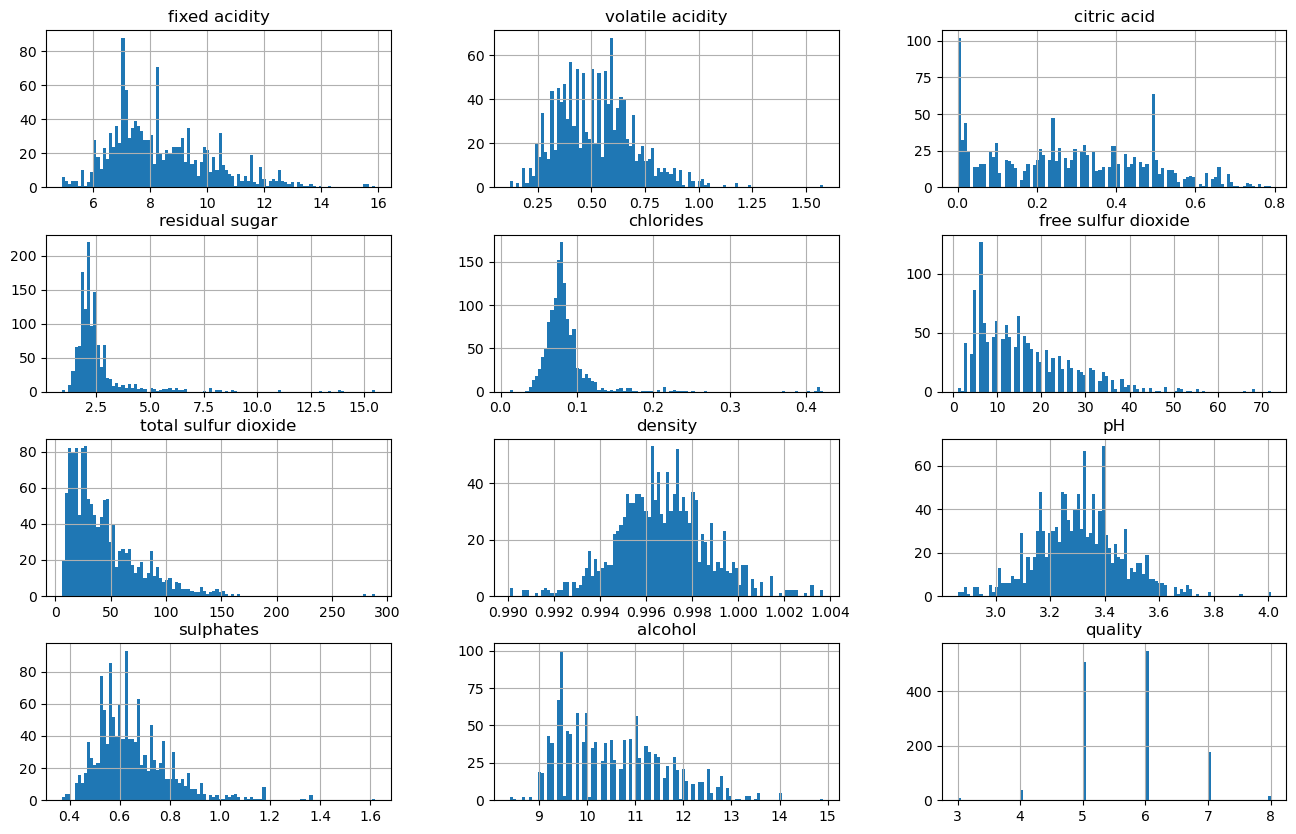

In [9]:
#red wine columns
red_train.hist(layout=(4, 3), figsize=(16, 10), bins=100)

array([[<Axes: title={'center': 'fixed acidity'}>,
        <Axes: title={'center': 'volatile acidity'}>,
        <Axes: title={'center': 'citric acid'}>],
       [<Axes: title={'center': 'residual sugar'}>,
        <Axes: title={'center': 'chlorides'}>,
        <Axes: title={'center': 'free sulfur dioxide'}>],
       [<Axes: title={'center': 'total sulfur dioxide'}>,
        <Axes: title={'center': 'density'}>,
        <Axes: title={'center': 'pH'}>],
       [<Axes: title={'center': 'sulphates'}>,
        <Axes: title={'center': 'alcohol'}>,
        <Axes: title={'center': 'quality'}>]], dtype=object)

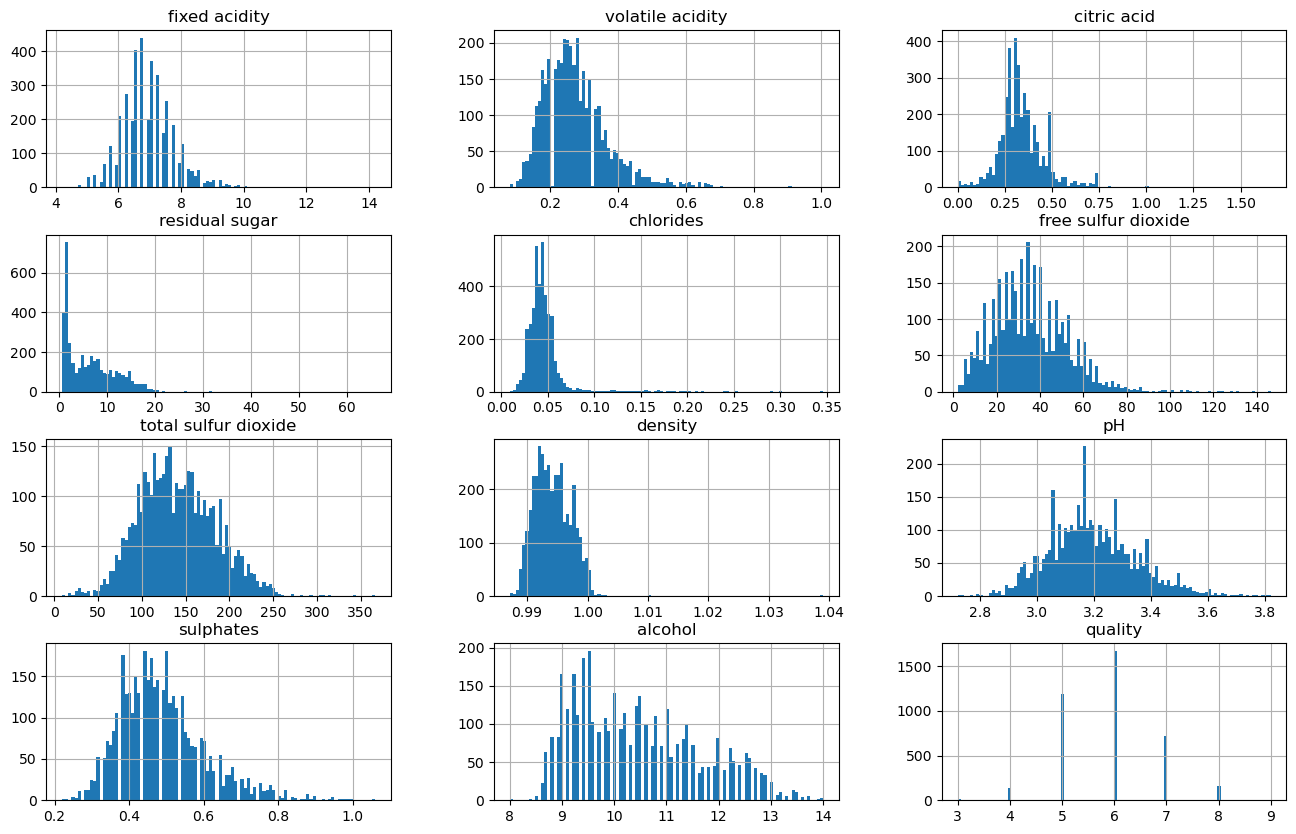

In [10]:
#white wine columns
white_train.hist(layout=(4, 3), figsize=(16, 10), bins=100)

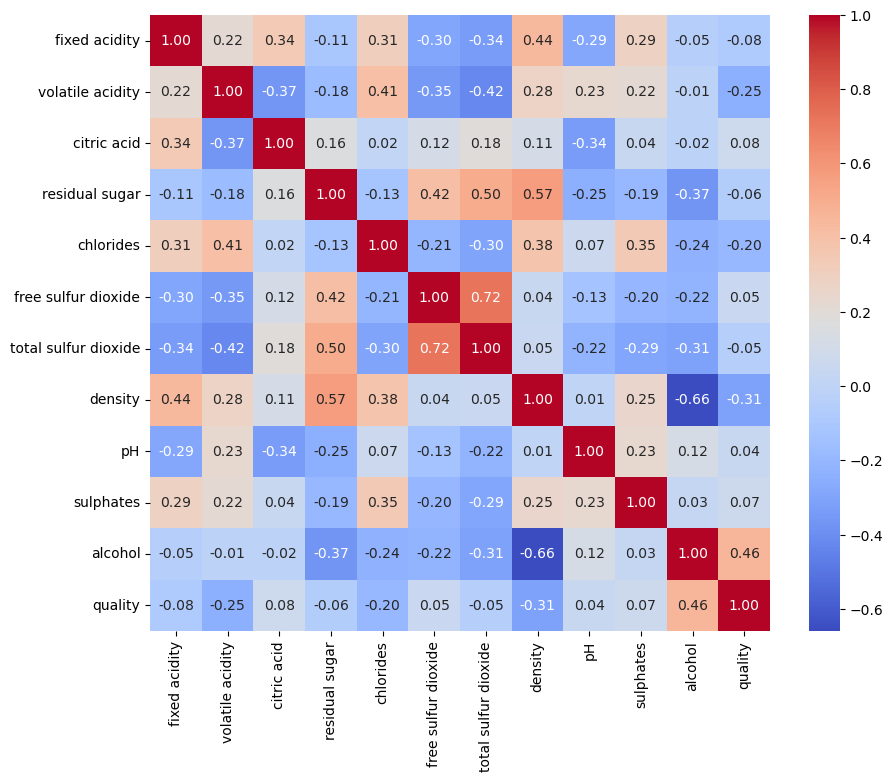

In [11]:
#heatmap for columns relationship
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
sb.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

## Training

In [30]:
from pycaret.regression import *

setup = setup(
    data=train_data,
    target="quality",
    train_size=0.999,
    fold=10,
    fold_strategy='stratifiedkfold',
    fold_shuffle=True,
    #normalize=True,
    #remove_outliers=True,
    #pca=True,
    #use_gpu=True,
    session_id=123,
)

,Description,Value
0,Session id,123
1,Target,quality
2,Target type,Regression
3,Original data shape,"(4158, 12)"
4,Transformed data shape,"(4158, 12)"
5,Transformed train set shape,"(4153, 12)"
6,Transformed test set shape,"(5, 12)"
7,Numeric features,11
8,Preprocess,True
9,Imputation type,simple


In [31]:
model = create_model('et')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.4055,0.3898,0.6244,0.5109,0.0948,0.0733
1,0.4294,0.4183,0.6467,0.4752,0.0978,0.0783
2,0.3923,0.3634,0.6028,0.5503,0.0909,0.0703
3,0.4158,0.3635,0.6029,0.5376,0.0915,0.0748
4,0.3828,0.3301,0.5745,0.5801,0.0878,0.0699
5,0.4300,0.3950,0.6285,0.4964,0.0949,0.0771
6,0.3847,0.3542,0.5951,0.5484,0.0921,0.0708
7,0.4027,0.3739,0.6114,0.5329,0.0928,0.0728
8,0.3920,0.3411,0.5841,0.5738,0.0910,0.0723


In [32]:
#model = finalize_model(blended_model)
model = finalize_model(model)
evaluate_model(model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [34]:
predictions = predict_model(model, data=test_data)
print(predictions.head())

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.4027,0.4027,0.6346,0.4940,0.0959,0.0733


      fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
4700            7.7              0.46         0.18             3.3      0.054   
2894            7.0              0.29         0.49             3.8      0.047   
4834            7.2              0.31         0.35             7.2      0.046   
4676            6.6              0.18         0.28             1.7      0.041   
5114            7.4              0.34         0.28            12.1      0.049   

      free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
4700                 18.0                 143.0  0.99392  3.12       0.51   
2894                 37.0                 136.0  0.99380  2.95       0.40   
4834                 45.0                 178.0  0.99550  3.14       0.53   
4676                 53.0                 161.0  0.99207  3.13       0.45   
5114                 31.0                 149.0  0.99677  3.22       0.49   

      alcohol  quality  prediction_label  
4700   

In [53]:
r_pred = predict_model(model, data=red_goal)
w_pred = predict_model(model, data=white_goal)

red_goal['quality'] = r_pred['prediction_label'].round().astype(int)
white_goal['quality'] = w_pred['prediction_label'].round().astype(int)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.3140,0.1397,0.3737,0.5000,0.0573,0.0580


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.2715,0.1003,0.3166,0.7634,0.0458,0.0460


array([[<Axes: title={'center': 'quality'}>, <Axes: >]], dtype=object)

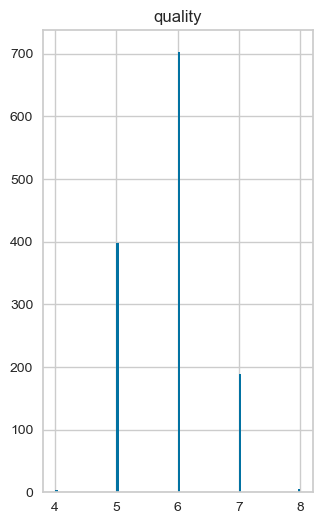

In [39]:
r_df = red_goal.copy()
w_df = white_goal.copy()

r_df['ID'] = ['red_' + str(i + 1) for i in range(len(r_df))]
w_df['ID'] = ['white_' + str(i + 1) for i in range(len(w_df))]

r_final = r_df[['ID', 'quality']]
w_final = w_df[['ID', 'quality']]

combined_df = pd.concat([r_final, w_final], ignore_index=True)
combined_df.to_csv("combined_predictions.csv", index=False)

combined_df.hist(layout=(1, 2), figsize=(8, 6), bins=100)